### Load dataset and rename columns
> Note: **Only AMST** are contained in df. HNK products where filtered.

In [3]:
import pandas as pd
import numpy as np
from re import sub

def column_name_to_snake_case(s):
    s = sub(r"[\/( \- ) ]", '_', s)
    s = sub(r"(___)|(__)", '_', s).lower()
    return s if s[-1] != '_' else s[:-1]

df = pd.read_csv(r'..\data\raw\Heineken - Data Science Use Case.csv', parse_dates=['Date/Time'])
df = (df.drop(columns=df.columns[0])
        .rename(columns={col:column_name_to_snake_case(col) for col in df.columns[1:]})
        .query('product == "AMST"')
     )

### Rows with null values

In [4]:
nulls = df[pd.isnull(df).any(axis=1)]
pd.isnull(df).any(axis=1).sum()

38

#### Analyzing target (color) null values
All color null values have no other null value besides the target column.
> They will be used as a test dataset

In [5]:
target = nulls.query('color.isnull()')
print(target.drop('color', axis=1).isnull().sum(axis=0))

# saving to parse dtypes faster later 
dtypes = {col:target[col].dtype for col in target.columns}

target.to_csv(r'..\data\test\test_data.csv', index=False)



job_id                0
date_time             0
roast_amount_kg       0
1st_malt_amount_kg    0
2nd_malt_amount_kg    0
mt_temperature        0
mt_time               0
wk_temperature        0
wk_steam              0
wk_time               0
total_cold_wort       0
ph                    0
extract               0
woc_time              0
whp_transfer_time     0
whp_rest_time         0
roast_color           0
1st_malt_color        0
2nd_malt_color        0
product               0
dtype: int64


#### Check non_target nulls
Null values from other column correspond to small percentage of total count of row count.

We will use interpolation with KNN to estimate missing values.

In [6]:
non_target = nulls.query('color.notnull()')
print('non_target nulls len:', len(non_target), '\n')
non_target = non_target.drop('color', axis=1).isnull().sum(axis=0)[lambda x: x >0].to_frame('null_count')
non_target['len_df'] = len(df)
non_target['ratio'] = non_target.null_count/len(df)

print(non_target)

# using interpolation to fill NAs on roast amount and ph
for col in ['roast_amount_kg', 'ph']:
    df[col] = df[col].interpolate(method='nearest')

print('\n\nnull values after interpolation')
pd.isnull(df).sum()[lambda x: x > 0]

non_target nulls len: 8 

                 null_count  len_df     ratio
roast_amount_kg           3     180  0.016667
ph                        5     180  0.027778


null values after interpolation


color    30
dtype: int64

### Features

In [7]:
import seaborn as sns
features = (df.select_dtypes(include='number')
             .drop(columns=['job_id','color'])
             .dropna()
             )
feature_cols = features.columns
features.describe()


,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,woc_time,whp_transfer_time,whp_rest_time,roast_color,1st_malt_color,2nd_malt_color
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000,180.000000,180.000000
mean,39.333655,13605.002525,6692.739271,67.800583,6741.181667,105.253674,6707.522222,6759.116250,942.518194,5.622933,15.279285,3136.455833,753.999028,14.495280,908.375,6.057028,6.019403
std,17.934671,1305.273361,1174.826388,2.813786,407.519540,0.582504,266.938186,544.103848,123.505920,0.680336,0.946991,543.580067,64.400781,0.007178,0.000,0.078990,0.013904
min,17.415013,0.000000,3996.957605,66.866813,6458.600000,97.659771,6170.500000,5929.700000,68.800000,2.295564,6.796530,107.500000,719.175000,14.476667,908.375,5.912500,5.912500
25%,24.509987,12593.275940,6069.167865,66.933041,6614.475000,105.202896,6557.500000,6552.662500,956.750000,5.555421,15.218249,3126.906250,731.000000,14.494583,908.375,6.020000,6.020000
50%,27.950033,14024.922935,6075.335730,67.002759,6684.887500,105.269124,6654.250000,6661.775000,963.200000,5.623254,15.442632,3146.525000,736.375000,14.494583,908.375,6.073750,6.020000
75%,54.663691,14083.290240,8326.369589,67.177043,6767.393750,105.373703,6804.750000,6791.581250,972.068750,5.720611,15.636795,3174.743750,743.900000,14.494583,908.375,6.127500,6.020000
max,88.042526,16092.750000,8462.077710,81.452861,11671.275000,105.718793,8202.250000,12621.575000,1088.975000,7.382991,16.320075,5743.725000,1241.625000,14.584167,908.375,6.127500,6.127500


### Check normality of features
All features were found to be normally distributed. 

roast_color	is constant, so it will be dropped.

In [14]:
from scipy.stats import shapiro, kstest

shapiro_p_value = [shapiro(df[col].dropna().values).pvalue for col in feature_cols]
kstest_p_value = [kstest(df[col].dropna().values, 'norm').pvalue for col in feature_cols]
print('len features:', len(features))
shapiro_p_value = [shapiro(features[col].values).pvalue for col in feature_cols]
kstest_p_value = [kstest(features[col].values, 'norm').pvalue for col in feature_cols]

normality_tests = pd.DataFrame(
    {'columns': feature_cols, 'shapiro_p_value': shapiro_p_value, 'kstest_p_value': kstest_p_value})

normality_tests['failed'] = normality_tests.apply(lambda row: 'yes' if row['shapiro_p_value'] > 0.05 or row['kstest_p_value'] > 0.05 else 'no', axis=1)
normality_tests

len features: 180


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


columns  shapiro_p_value  kstest_p_value failed
0      roast_amount_kg     2.219297e-14             0.0     no
0      roast_amount_kg     2.617168e-14             0.0     no
1   1st_malt_amount_kg     1.174284e-22             0.0     no
2   2nd_malt_amount_kg     2.723439e-17             0.0     no
3       mt_temperature     2.806055e-25             0.0     no
4              mt_time     1.103082e-25             0.0     no
5       wk_temperature     1.643726e-27             0.0     no
6             wk_steam     6.888419e-13             0.0     no
7              wk_time     1.118321e-23             0.0     no
8      total_cold_wort     2.281583e-26             0.0     no
9                   ph     7.060164e-21             0.0     no
9                   ph     5.290202e-20             0.0     no
10             extract     3.670779e-24             0.0     no
11            woc_time     3.271764e-23             0.0     no
12   whp_transfer_time     6.501128e-24             0.0     no
13       whp_rest_time     2.656962e-28             0.0     no
14         roast_color     1.000000e+00             0.0    yes
15      1st_malt_color     5.987649e-16             0.0     no
16      2nd_malt_color     3.875118e-28             0.0     no

In [15]:
features = features.drop('roast_color', axis=1)

### Outlier Detection

35 rows contain at least one outlier


,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,woc_time,whp_transfer_time,whp_rest_time,1st_malt_color,2nd_malt_color
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4866.525,NaN,14.584167,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1241.625,NaN,NaN,NaN
38,NaN,NaN,NaN,77.303098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,983.625,NaN,NaN,NaN
51,NaN,NaN,NaN,77.369326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1275
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,965.350,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9125
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9125
68,NaN,NaN,NaN,NaN,NaN,NaN,8202.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


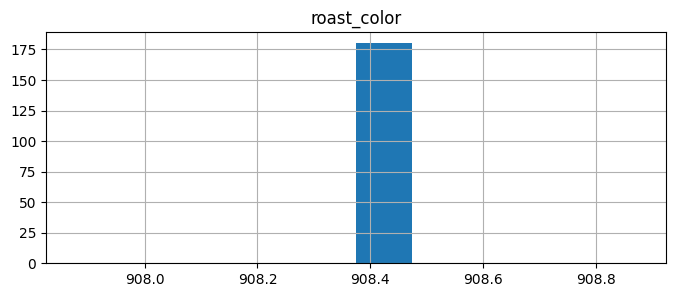

In [28]:
import numpy as np
failed = df[normality_tests.query('shapiro_p_value > 0.05 or kstest_p_value > 0.05')['columns'].values]
failed.hist(figsize=(8, 3))


array([[<Axes: title={'center': 'roast_amount_kg'}>,
        <Axes: title={'center': '1st_malt_amount_kg'}>,
        <Axes: title={'center': '2nd_malt_amount_kg'}>,
        <Axes: title={'center': 'mt_temperature'}>],
       [<Axes: title={'center': 'mt_time'}>,
        <Axes: title={'center': 'wk_temperature'}>,
        <Axes: title={'center': 'wk_steam'}>,
        <Axes: title={'center': 'wk_time'}>],
       [<Axes: title={'center': 'total_cold_wort'}>,
        <Axes: title={'center': 'ph'}>,
        <Axes: title={'center': 'extract'}>,
        <Axes: title={'center': 'woc_time'}>],
       [<Axes: title={'center': 'whp_transfer_time'}>,
        <Axes: title={'center': 'whp_rest_time'}>,
        <Axes: title={'center': '1st_malt_color'}>,
        <Axes: title={'center': '2nd_malt_color'}>]], dtype=object)

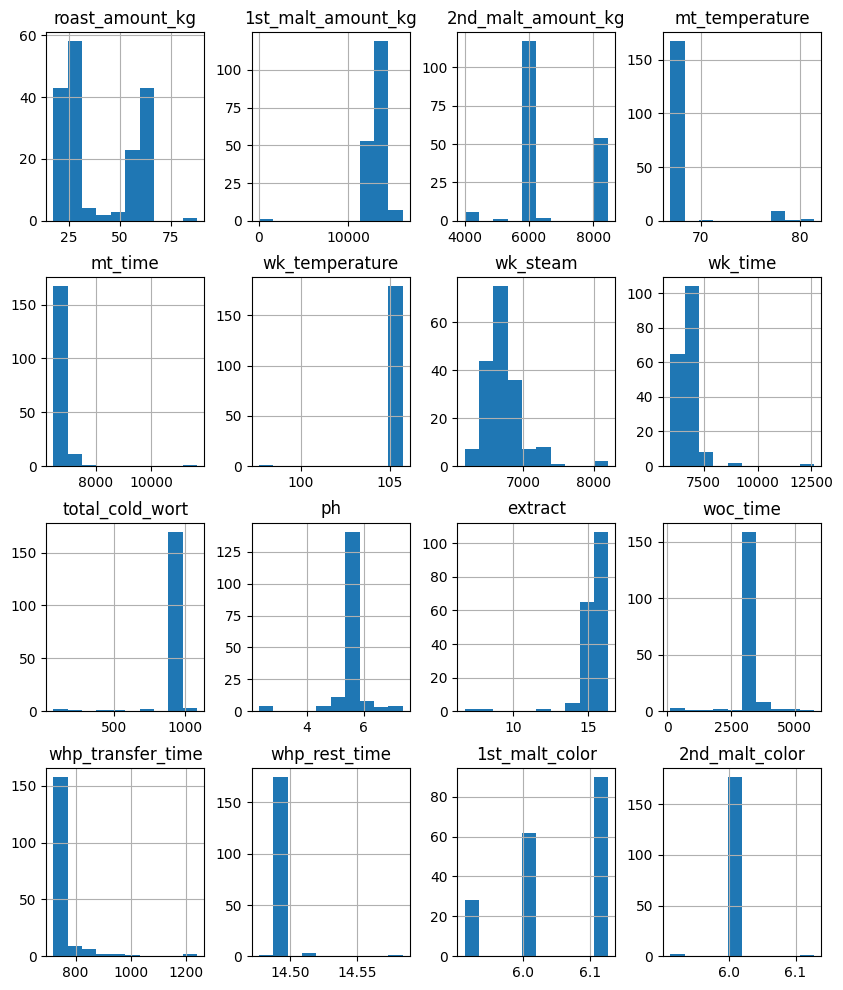

In [8]:
df[[col for col in feature_cols if col not in failed.columns]].hist(figsize=(10,12))

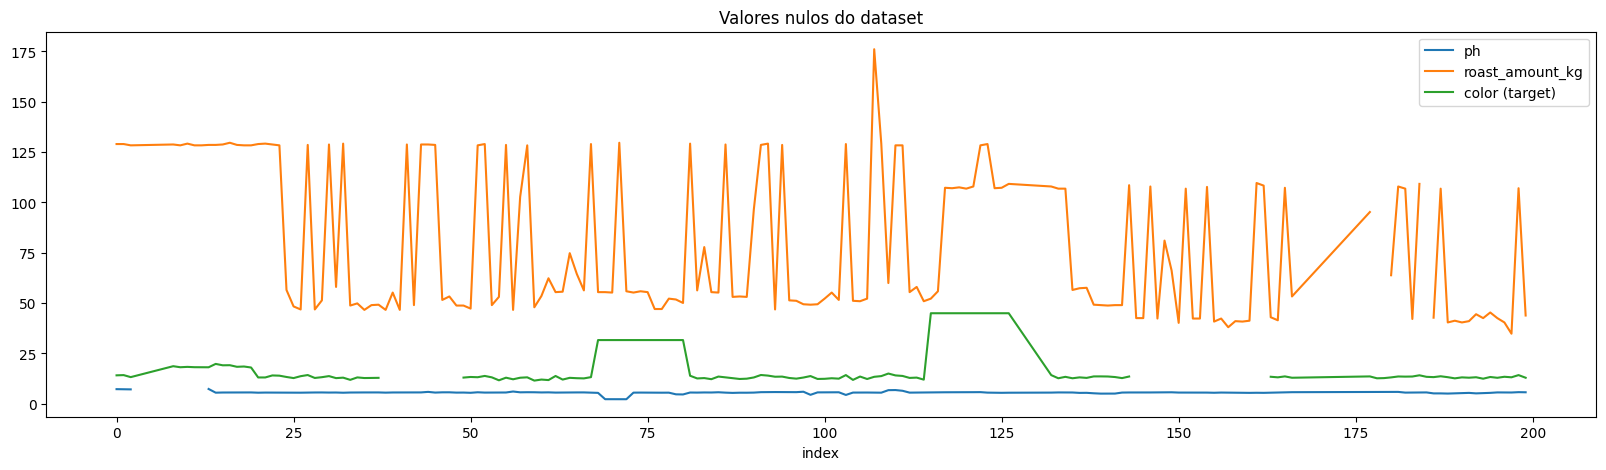

In [9]:
df['base_amount_kg'] = df['1st_malt_amount_kg'] + df['2nd_malt_amount_kg']
# Multiplied by 2 just offset lines a little bit
df.roast_amount_kg = df.roast_amount_kg*2
df['color (target)'] = df.color

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
ax = df.sort_values('date_time').reset_index().plot(x='index', y=['ph', 'roast_amount_kg', 'color (target)'])
ax.set(title='Valores nulos do dataset')

# undo changes to dataset
df.roast_amount_kg = df.roast_amount_kg/2

### Evaluating pearson correlation
Highly correlated variables:
    - 1st and 2nd malt amount
    - woc time and extract
    - total cold wort with extract and wot time

(<Axes: title={'center': 'Pearson Correlation plot'}>,
 <Axes: title={'center': 'Absolute Pearson Correlation by Feature'}, xlabel='columns'>)

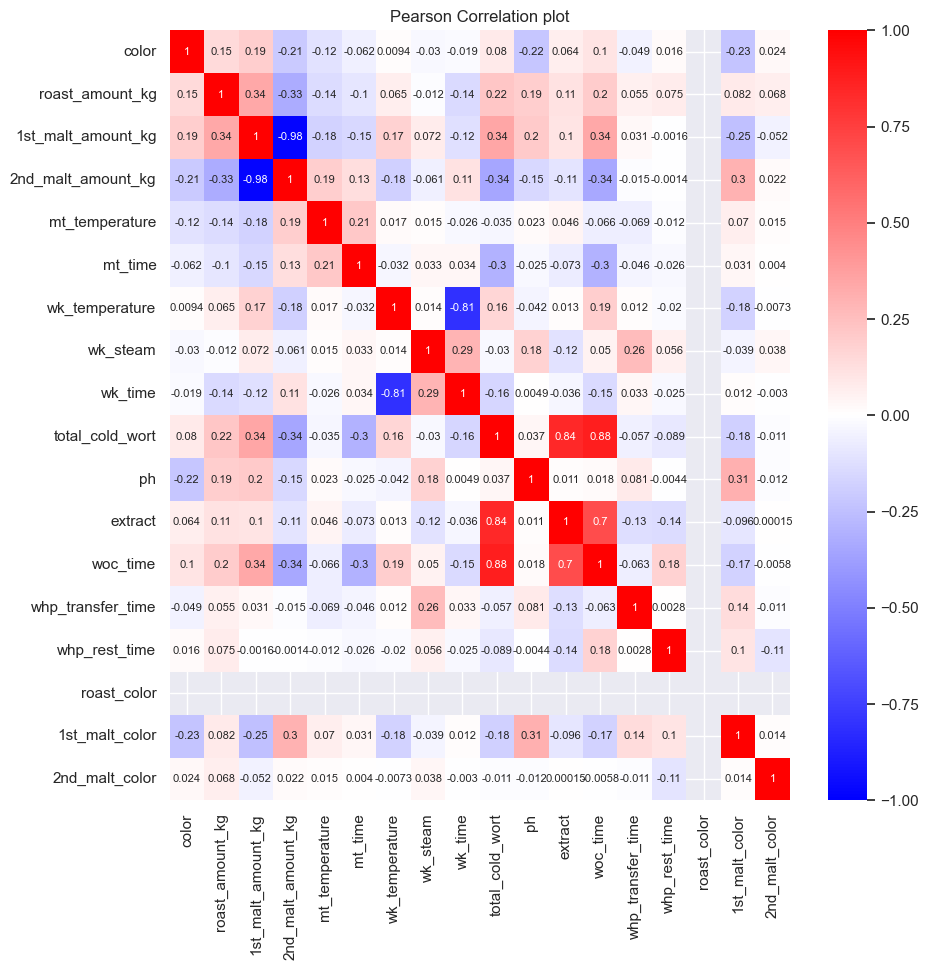

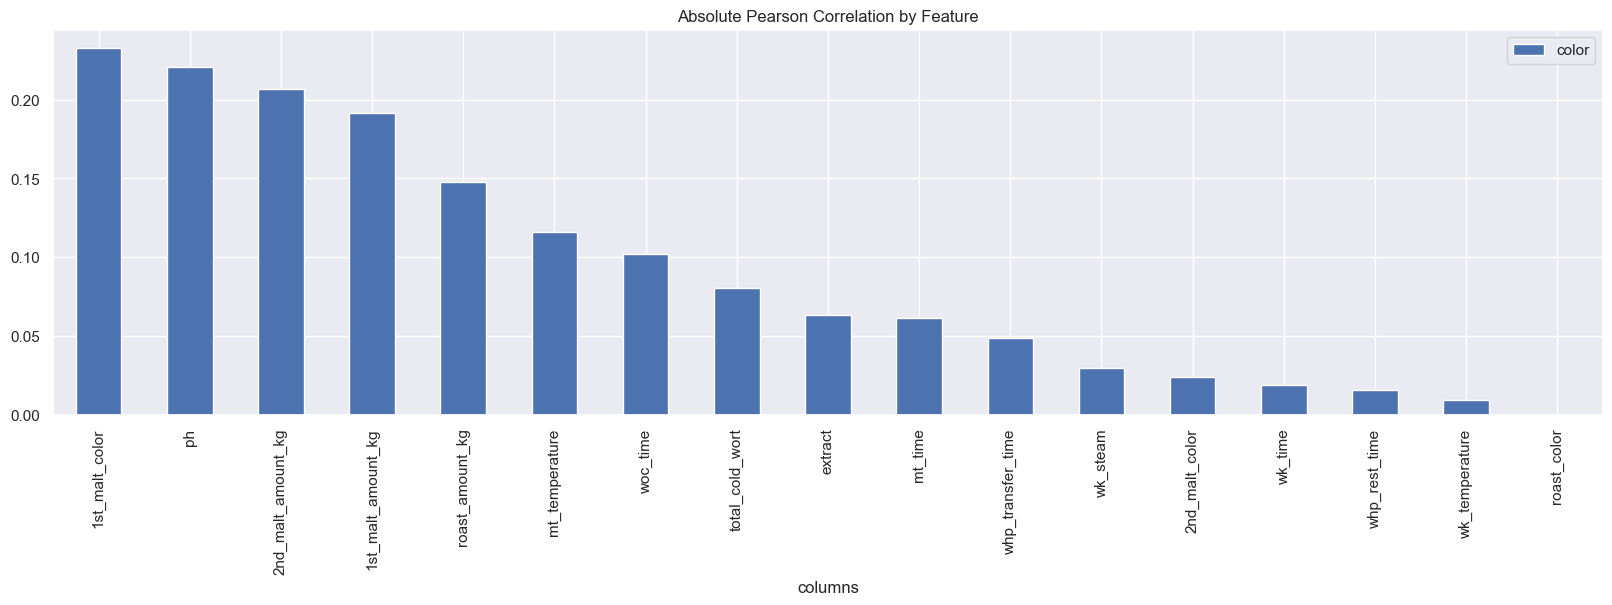

In [29]:
from typing import Literal

def plot_correlation_heatmap(df:pd.DataFrame, corr_method:Literal['pearson', 'spearman', 'kendall']):
    plt.rcParams["figure.figsize"] = (10,10)
    corr_df = df.dropna().corr(corr_method)
    ax = sns.heatmap(corr_df, 
                    vmin=-1, vmax=1, center=0, 
                    cmap='bwr', annot=corr_df.values,annot_kws={'fontsize':8})
    ax.set(title=f'{corr_method.title()} Correlation plot')
    
    # absolute correlation 
    plt.rcParams["figure.figsize"] = (20,5)
    ax2  = (corr_df[['color']].abs()
                              .sort_values('color', ascending=False)
                              .reset_index(names=['columns'])
                              .query('columns != "color"')
                              .plot.bar(x='columns', y='color'))
    ax2.set(title=f'Absolute {corr_method.title()} Correlation by Feature')
    return ax, ax2

plot_correlation_heatmap(df[['color'] + list(feature_cols)], 'pearson')

<Axes: >

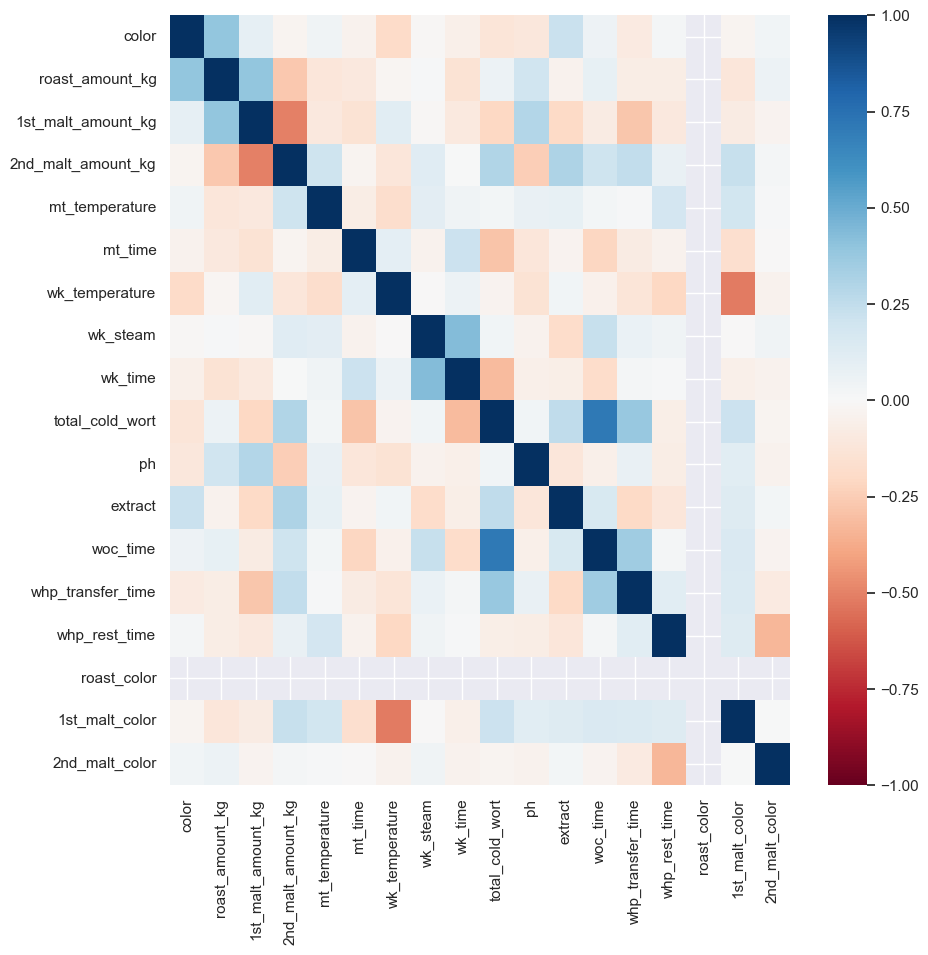

In [11]:
# sns.heatmap()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

d = df[['color'] + list(feature_cols)].dropna().corr('spearman')

sns.heatmap(d, vmin=-1, vmax=1, center=0, cmap='RdBu')



<Axes: >

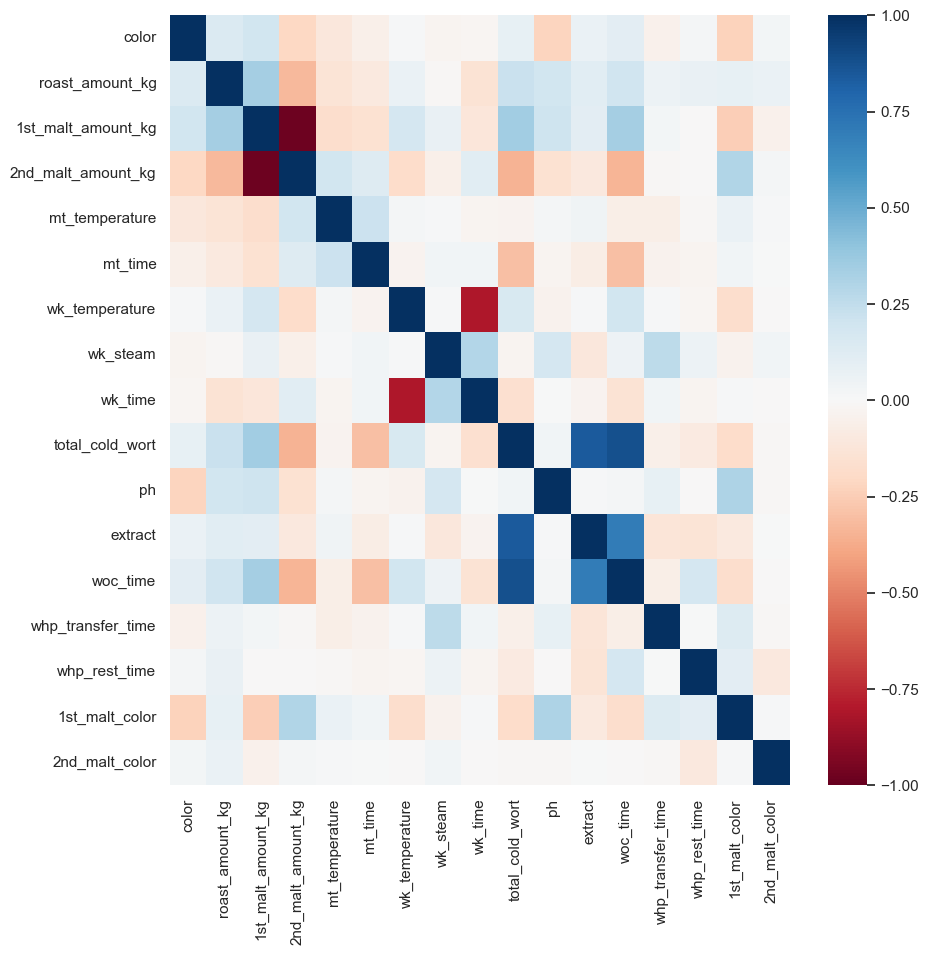

In [12]:
_cols = ['color'] + list(feature_cols)
for c  in failed.columns[:3]: _cols.remove(c)
d = df[_cols].dropna().corr('pearson')

sns.heatmap(d, vmin=-1, vmax=1, center=0, cmap='RdBu')

<Axes: >

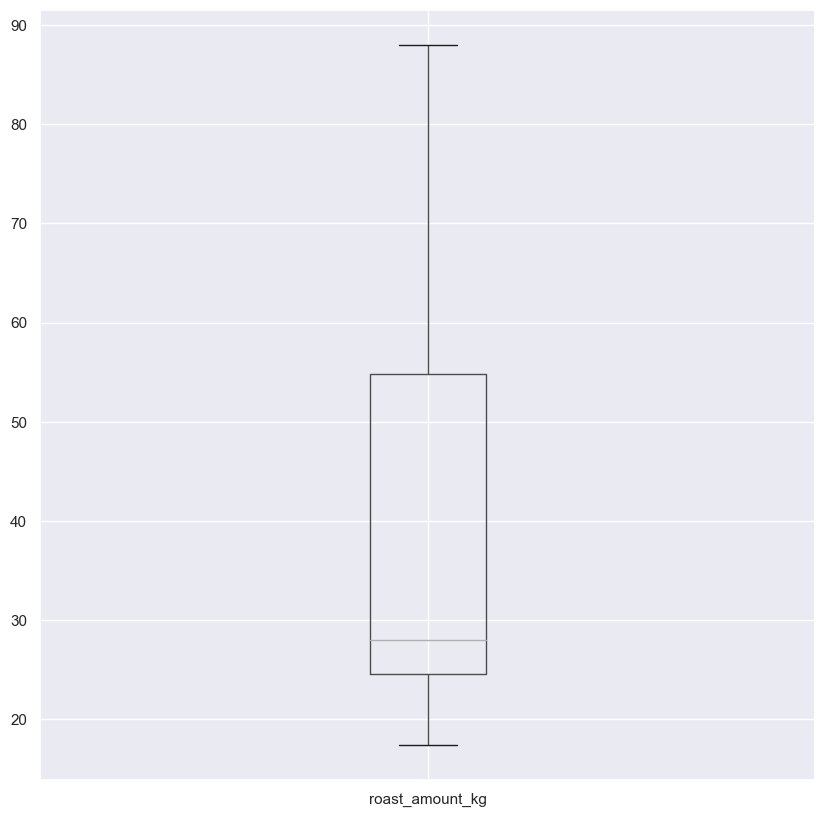

In [13]:
df[['roast_amount_kg']].dropna().boxplot()